# Moving Box - Encoder Decoder

In [109]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect an ensemble of box data

In [161]:
img_collections = get_processed_moving_box_squares(augment=True)
img_collections = center_collections(img_collections)
# number of images for each collection
num_per_collection = [x.shape[0] for x in img_collections]
# number of collections
n_collection = len(img_collections)
# total number of images
total_imgs = sum(num_per_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(n_collection, total_imgs))

{'images:': 'bigsquare-vertical-4', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'square-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-4', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-vertical', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-5', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-diagnal', 'dim': (56, 32, 32)}
{'images:': 'bigsquare-vertical-5', 'dim': (56, 32, 32)}
{'images:': 'square-diagnal', 'dim': (56, 32, 32)}

After Augmentation: img_collections has 26 collections, 1456 images in total


In [162]:
test_file = "data/moving-box/processed/Box/test/square-vertical.npz"
test_imgs = load_imgs(test_file)

{'images:': 'square-vertical', 'dim': (56, 32, 32)}


## Sample Train and Dev

In [163]:
def sample(batch_size = 8, train=True, gap = 1):
    train_ind_collection, val_ind_collection = zip(*[split_train_dev(x) for x in img_collections])
          
    # get average number of training for each class
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i in range(n_collection):
        data = train_ind_collection[i] if train else val_ind_collection[i]
        try:
            s = np.random.choice(list(filter(lambda x:x<num_per_collection[i]-gap-1, data)),avg_num_per_class, replace=False)
            before_ind.append(s)
        except:
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classed = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([img_collections[i][before_ind[i]] for i in selected_classed], axis = 0)
    after_imgs = np.concatenate([img_collections[i][after_ind[i]] for i in selected_classed], axis = 0)
    mid_imgs = np.concatenate([img_collections[i][mid_ind[i]] for i in selected_classed], axis = 0)
    
    clipped = np.random.choice(range(before_imgs.shape[0]), batch_size, replace=False)
    before_imgs = before_imgs[clipped]
    mid_imgs = mid_imgs[clipped]
    after_imgs = after_imgs[clipped]
    return (before_imgs, after_imgs), mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(batch_size, True, gap = gap)

def sample_dev(batch_size = 8, gap = 1):  return sample(batch_size, False, gap)

## Sample Test

In [164]:
def sample_test(batch_size = 8, gap = 1):  
    return sample_pred_frames(test_imgs, gap, batch_size)

## Take a look at Training data

Range of Image Piece Value: [-1.0, 1.0]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


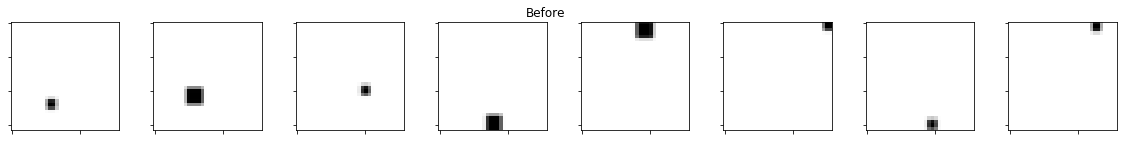

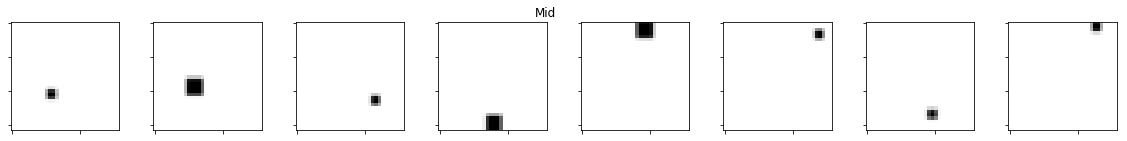

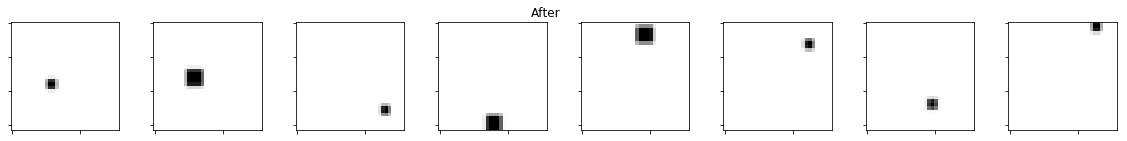

In [165]:
(test_before, test_after), test_mid = sample_train(batch_size=8, gap=5)
print("Range of Image Piece Value: [{}, {}]".format(np.min(test_mid), np.max(test_mid)))
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (20, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

## Sample of Test Data

before, after, mid = sample_test(batch_size=8, gap=5)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (20, 2)
plot_images(before, size, "Before")
plot_images(mid, size, "Mid")
plot_images(after, size, "After")

# Model

## Param

In [166]:
feature_channel = 64

gap = 5
batch_size = 64

learning_rate = 1e-4
beta = 0.9 # defalut 0.9 for adam
num_iteration = 3000
relu_alpha = 0.01

# Encoder

In [167]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, 8 x 8 x feature_channel]
    """
    img = tf.reshape(img, [-1, 32, 32, 1])
    x = tf.layers.conv2d(img, filters = 4, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)

    x = tf.layers.conv2d(x, filters = 8, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)

    x = tf.layers.conv2d(x, filters = 16, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)

    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    x = tf.contrib.layers.flatten(x)
    return x

# Decoder

In [168]:
def decode(feature1, feature2, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8 x 8 x feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """

    x = feature1 * w1  + feature2 * (1-w1) + bias

    x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
    x = tf.reshape(x, [-1, 8, 8, 128])
    
    x = tf.layers.conv2d(x, filters = 8, kernel_size=3, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)

    x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)

    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
    x = tf.layers.batch_normalization(x,  axis=3, training=is_training)

    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
    img = tf.reshape(img, [-1, 32, 32, 1])
    return img

## Generator

In [169]:
def generate(x1, x2,  is_training=True):
    with tf.variable_scope("generator") as scope:
        feature1, feature2 = encode(x1, is_training), encode(x2, is_training)
        img = decode(feature1, feature2, is_training)
        return img

### Loss

In [170]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

### Get a Batch Generation

In [171]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [172]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [173]:
def report_loss(before, after, mid, num_run = 1000):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    return np.mean([sess.run(G_loss, dic) for _ in range(num_run)]) / batch_size * 255

## Computational Graph

In [174]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

with tf.variable_scope("generator") as scope:
    w1   = tf.Variable(0.5, "encoder weight")
    bias = tf.Variable(0.,   "encoder bias")


G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [175]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6):
    g_losses = []
    for i in range(num_iteration):
        (real_before, real_after), real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        g_losses.append(G_loss_curr)
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {}".format(i))
    return g_losses

# Train !

Iteration 0:  G_loss = 279.75811767578125


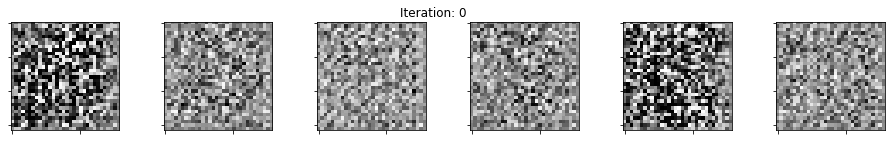

Iteration 200:  G_loss = 121.56302642822266


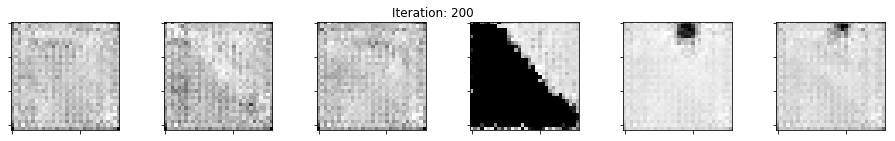

Iteration 400:  G_loss = 112.1485595703125


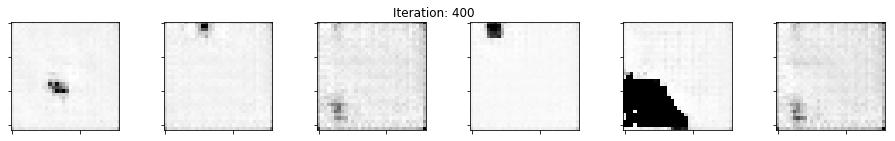

Iteration 600:  G_loss = 71.51953887939453


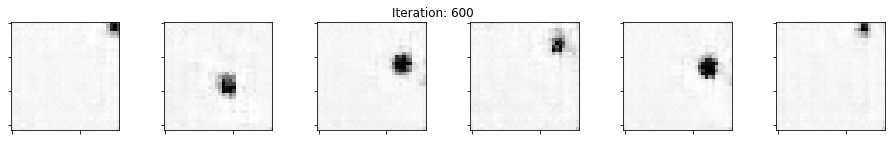

Iteration 800:  G_loss = 91.99484252929688


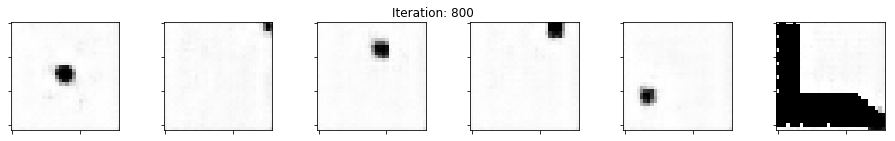

Iteration 1000:  G_loss = 90.736083984375


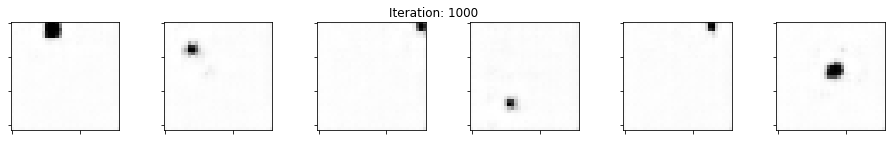

Iteration 1200:  G_loss = 52.079837799072266


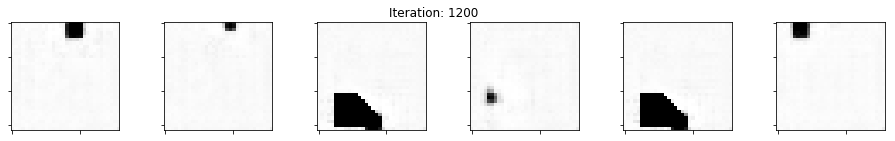

Iteration 1400:  G_loss = 48.94377136230469


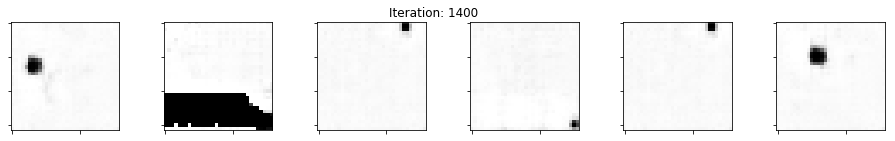

Iteration 1600:  G_loss = 24.549087524414062


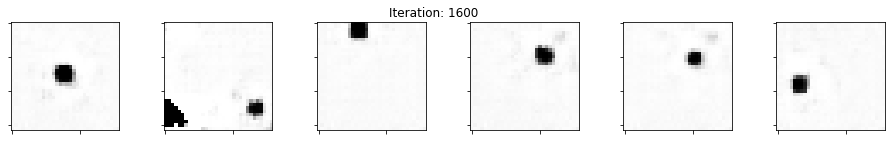

Iteration 1800:  G_loss = 17.335081100463867


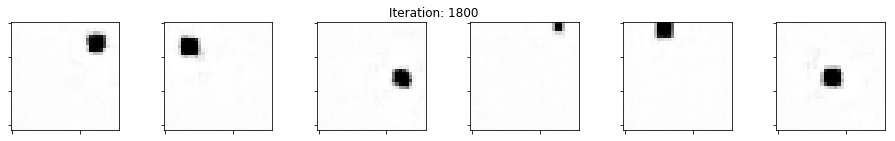

Iteration 2000:  G_loss = 14.911332130432129


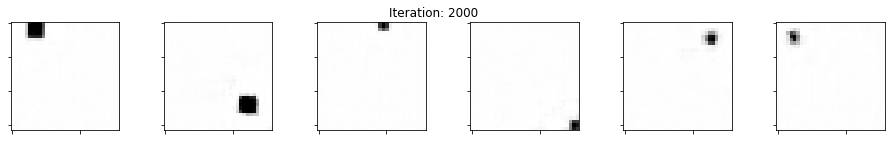

Iteration 2200:  G_loss = 11.971243858337402


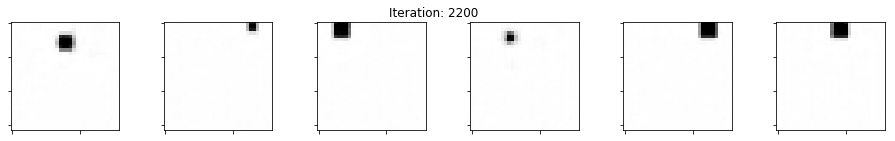

Iteration 2400:  G_loss = 11.527022361755371


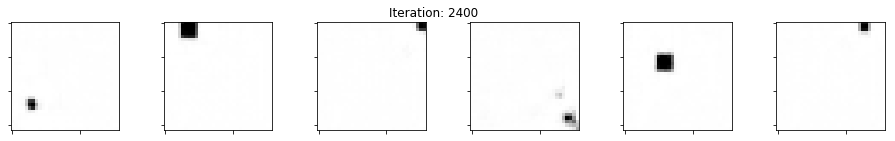

Iteration 2600:  G_loss = 6.674102783203125


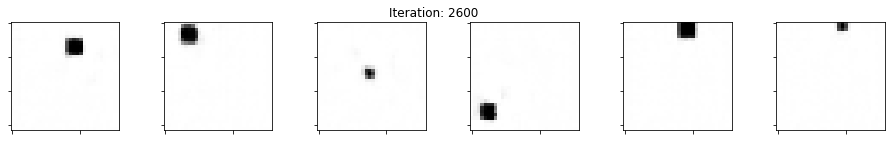

Iteration 2800:  G_loss = 13.279614448547363


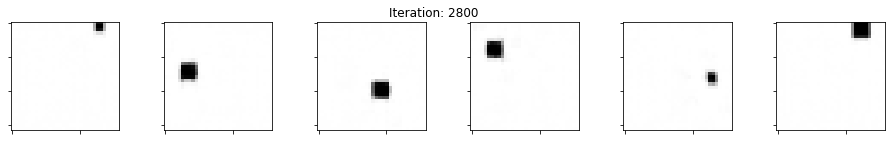

In [176]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 200, show_loss_every = 200)

## Plot of Learning Curve

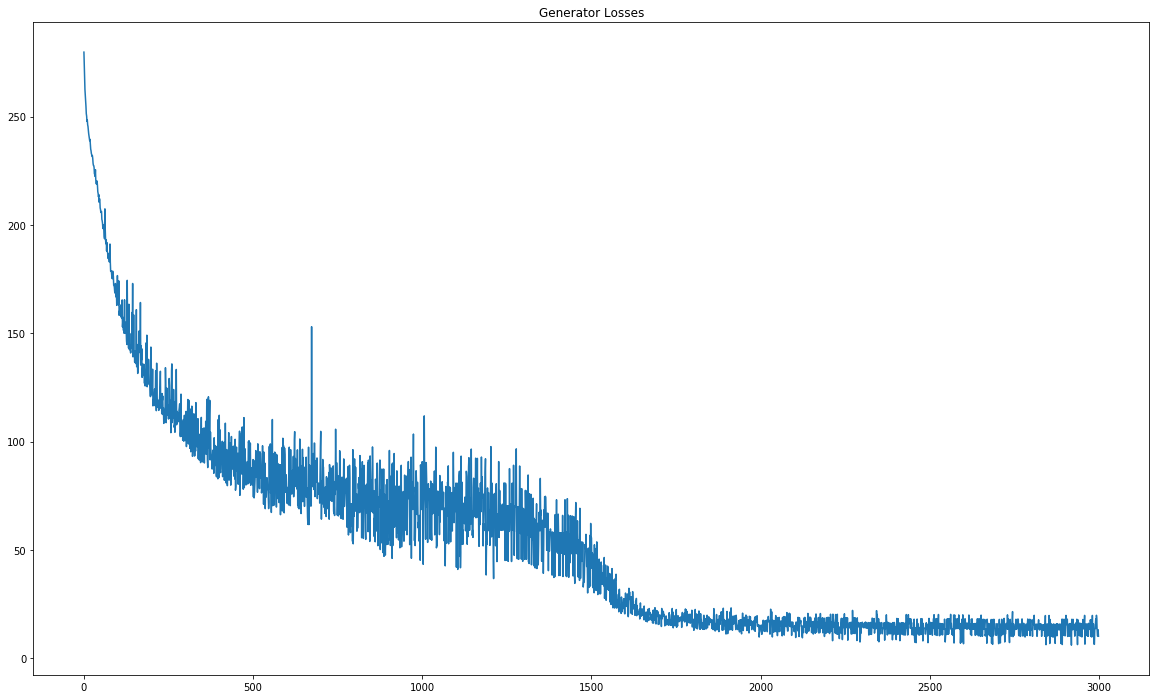

In [177]:
figsize = (20, 12)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

# Evaluate !

## - Evaluate on Training Data

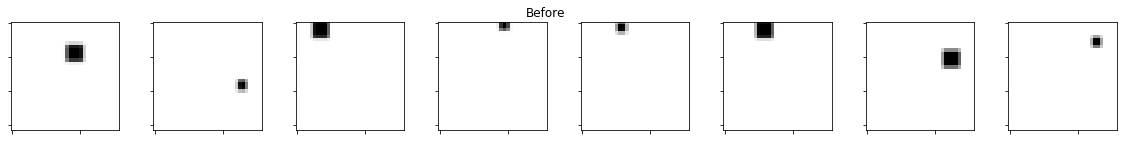

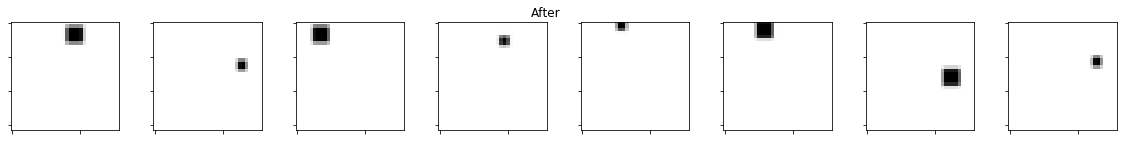

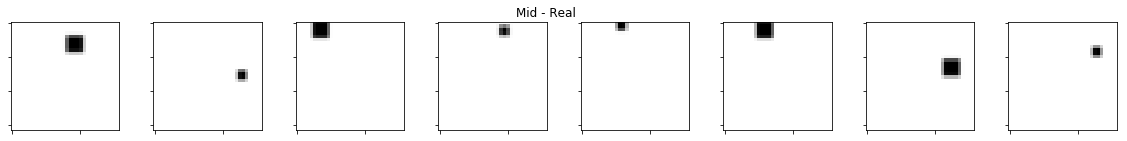

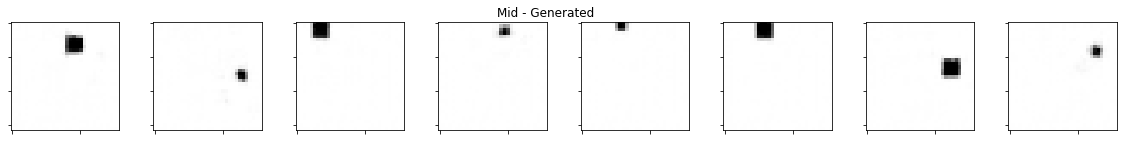

Training Loss = 8.809551782906055


In [178]:
def eval_train(num=4, gap = 3):
    (before, after), mid = sample_train(num, gap)
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")
    
    loss = report_loss(before, after, mid)
    print("Training Loss = {}".format(loss))

eval_train(num = 8, gap = gap)

## - Evaluate on Validation Data

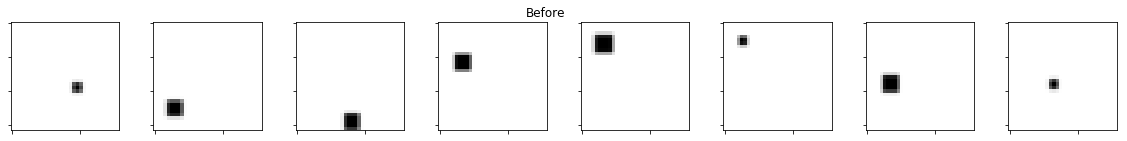

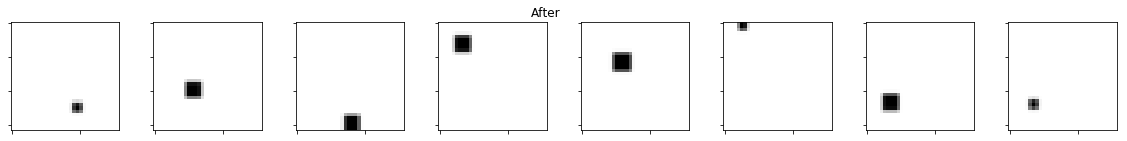

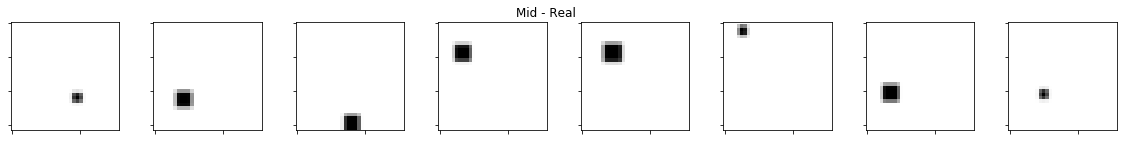

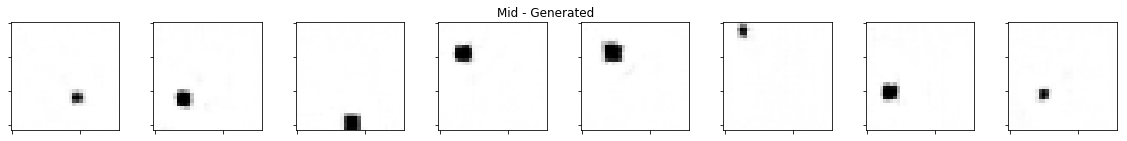

Validation Loss = 14.882072433829308


In [179]:
def eval_val(num = 4, gap = 1, num_test = 1000):
    (before, after), mid = sample_dev(num, gap)
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")
    
    loss = report_loss(before, after, mid)
    print("Validation Loss = {}".format(loss))

eval_val(num = 8, gap = gap)

## - Evaluate on Test Data

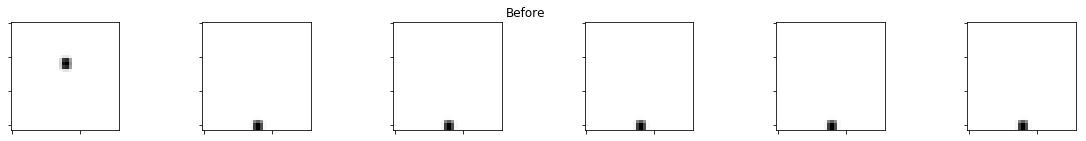

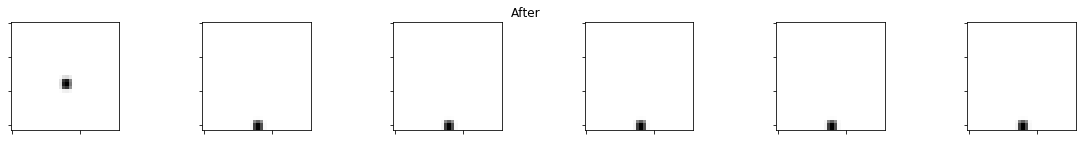

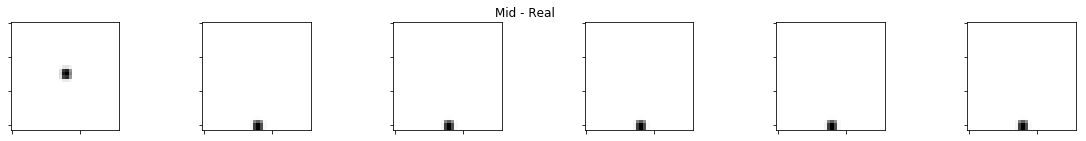

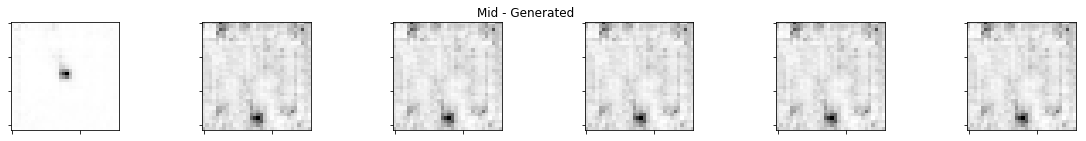

Test Loss = 19.10365730524063


In [180]:
def show_val(num = 6, gap = 3):
    before, after, mid = sample_test(num, gap)
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

def eval_test(num = 6, gap = 3):
    show_val(num, gap)
    before, after, mid = sample_test(num, gap)
    loss = report_loss(before, after, mid)
    print("Test Loss = {}".format(loss))

eval_test(gap=gap)

## Display trained weigth and bias

In [181]:
w1_trained, bias_trained = sess.run([w1, bias])
print("w1 = {} | bias = {}".format(w1_trained, bias_trained))

w1 = 0.4918527901172638 | bias = 0.004645159468054771
